## License

Copyright 2020 Google LLC

Licensed under the the Apache License v2.0 with LLVM Exceptions (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://llvm.org/LICENSE.txt

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [115]:
import requests
import os
import logging
import argparse
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
cache_file = "cache.json"
token = f'Bearer {os.getenv("BUILDKITE_API_TOKEN")}'
builds = []

In [165]:
if os.path.exists(cache_file):
    with open(cache_file) as f:
        builds = json.load(f)
        print(f'loaded {len(builds)} entries') 

loaded 9938 entries


In [170]:
# load new jobs from Buildkite API
if True:
    existing = set()
    for j in builds:
        existing.add(j['id'])

    # uncomment to reset
#     builds = []
#     existing = set()
    page = 1
    stop = False
    while not stop:
        print('loading page', page)
        re = requests.get('https://api.buildkite.com/v2/organizations/llvm-project/builds',
                          params={'page': page},
                          headers={'Authorization': token})
        if re.status_code != 200:
            print('response status', re.status_code, re)
            break
        x = re.json()
        if x == []:
            print('empty response')
            break
        for j in x:
            if j['id'] in existing:
                print('found existing job', j['id'])
                stop = True
                break
            # TODO: skip running jobs            
            if (j['state'] == 'running') or (j['state'] == 'scheduled'):
                print(j['web_url'], 'is', j['state'], 'skipping')
                continue
            builds.append(j)
        page += 1
    print(len(builds), 'jobs in total')    
    with open(cache_file, 'w') as f:
        json.dump(builds, f)
    print(f'saved {len(builds)} entries')

loading page 1
https://buildkite.com/llvm-project/premerge-checks/builds/4227 is running skipping
https://buildkite.com/llvm-project/diff-checks/builds/4974 is running skipping
https://buildkite.com/llvm-project/premerge-checks/builds/4226 is running skipping
https://buildkite.com/llvm-project/diff-checks/builds/4972 is running skipping
https://buildkite.com/llvm-project/premerge-checks/builds/4225 is running skipping
https://buildkite.com/llvm-project/diff-checks/builds/4971 is running skipping
https://buildkite.com/llvm-project/premerge-checks/builds/4224 is running skipping
https://buildkite.com/llvm-project/diff-checks/builds/4970 is running skipping
https://buildkite.com/llvm-project/premerge-checks/builds/4223 is running skipping
https://buildkite.com/llvm-project/premerge-checks/builds/4222 is running skipping
https://buildkite.com/llvm-project/diff-checks/builds/4969 is running skipping
https://buildkite.com/llvm-project/diff-checks/builds/4968 is running skipping
https://build

In [171]:
d = {
    'id': [],
    'number': [],
    'pipeline': [],
}

jobs = {
    'pipeline': [],
    'name': [],
    'step_key': [],
    'state': [],
    'exit_status': [],
    'agent_id': [],
    'agent_name': [],
    'runnable_at': [],
    'started_at': [],
    'wait_duration': [],
    'finished_at': [],
    'run_duration': [],
}

sec = np.timedelta64(1, 's')
for b in builds:
    d['id'].append(b['id'])
    d['number'].append(b['number'])
    d['pipeline'].append(b['pipeline']['slug'])
    for x in b['jobs']:
        if x['state'] in ['waiting_failed', 'canceled', 'skipped', 'broken']:
            continue
        try:
            jobs['pipeline'].append(b['pipeline']['slug'])
            jobs['name'].append(x['name'])
            jobs['step_key'].append(x['step_key'] if 'step_key' in x else '')
            jobs['state'].append(x['state'] )
            jobs['exit_status'].append(x['exit_status'] if 'exit_status' in x else -1)
            jobs['agent_id'].append(x['agent']['id'] if 'agent' in x else '')
            jobs['agent_name'].append(x['agent']['name'] if 'agent' in x else '')
            runnable = np.datetime64(x['runnable_at'].replace('Z', ''))
            started = np.datetime64(x['started_at'].replace('Z', ''))
            finished = np.datetime64(x['finished_at'].replace('Z', ''))
            jobs['runnable_at'].append(runnable)
            jobs['started_at'].append(started)
            jobs['wait_duration'].append((started - runnable) / sec)
            jobs['finished_at'].append(finished)
            jobs['run_duration'].append((finished - started) / sec)
        except Exception as e:
            print(x)
            raise e            
jobs = pd.DataFrame(jobs)

In [122]:
jobs.pipeline.unique()

array(['premerge-checks', 'diff-checks', 'llvm-master-build',
       'cleanup-branches', 'llvm-releases'], dtype=object)

In [108]:
jobs

,pipeline,name,step_key,state,exit_status,agent_id,agent_name,runnable_at,started_at,wait_duration,finished_at,run_duration
0,premerge-checks,:seedling: setup,None,passed,0,5725b783-8dbd-4f2a-868b-43672fda1517,premerge-debian-79cddc6ddb-xcdj8-2,2020-07-16 12:50:04,2020-07-16 12:50:08.673,4.673,2020-07-16 12:50:25.259,16.586
1,premerge-checks,:linux: build and test linux,linux,failed,-1,5725b783-8dbd-4f2a-868b-43672fda1517,premerge-debian-79cddc6ddb-xcdj8-2,2020-07-16 12:50:25,2020-07-16 12:50:28.668,3.668,2020-07-16 12:59:19.455,530.787
2,premerge-checks,:windows: build and test windows,windows,passed,0,f4f2789e-50aa-4dfb-88e9-267df8227508,w64,2020-07-16 12:50:25,2020-07-16 12:50:29.645,4.645,2020-07-16 13:04:03.301,813.656
3,premerge-checks,:spiral_note_pad: report,None,passed,0,152a7c38-8e6c-438b-8123-fafb92ff2afd,premerge-debian-79cddc6ddb-snd9j-2,2020-07-16 13:04:03,2020-07-16 13:04:12.266,9.266,2020-07-16 13:04:23.550,11.284
4,diff-checks,:seedling: setup,None,passed,0,5725b783-8dbd-4f2a-868b-43672fda1517,premerge-debian-79cddc6ddb-xcdj8-2,2020-07-16 12:49:18,2020-07-16 12:49:18.663,0.663,2020-07-16 12:49:20.104,1.441
...,...,...,...,...,...,...,...,...,...,...,...,...
31143,llvm-releases,ninja all,None,failed,1,1346c13a-6aca-49cb-b76f-9c248c2e53eb,2b3f2bb62dfe-1,2019-11-07 17:04:11,2019-11-07 17:04:18.898,7.898,2019-11-07 17:04:23.296,4.398
31144,llvm-releases,,None,failed,9009,1346c13a-6aca-49cb-b76f-9c248c2e53eb,2b3f2bb62dfe-1,2019-11-07 16:59:15,2019-11-07 16:59:16.770,1.770,2019-11-07 17:02:41.360,204.590
31145,llvm-releases,,None,failed,9009,1346c13a-6aca-49cb-b76f-9c248c2e53eb,2b3f2bb62dfe-1,2019-11-07 16:59:15,2019-11-07 17:02:41.760,206.760,2019-11-07 17:02:46.147,4.387
31146,llvm-releases,,None,failed,1,1346c13a-6aca-49cb-b76f-9c248c2e53eb,2b3f2bb62dfe-1,2019-11-07 16:00:46,2019-11-07 16:57:53.596,3427.596,2019-11-07 16:58:07.712,14.116


In [172]:
ds = jobs[jobs['pipeline'] == 'premerge-checks'][jobs['step_key'] == 'windows'][jobs['state']=='passed'][~jobs['agent_name'].str.startswith('buildkite-')]

/usr/local/google/home/goncharov/etc/merge-checks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [151]:
ds

,pipeline,name,step_key,state,exit_status,agent_id,agent_name,runnable_at,started_at,wait_duration,finished_at,run_duration
2,premerge-checks,:windows: build and test windows,windows,passed,0,f4f2789e-50aa-4dfb-88e9-267df8227508,w64,2020-07-16 12:50:25,2020-07-16 12:50:29.645,4.645,2020-07-16 13:04:03.301,813.656
9,premerge-checks,:windows: build and test windows,windows,passed,0,1ee7462f-3202-4272-a755-7e2850e59af4,w3,2020-07-16 12:41:56,2020-07-16 12:42:00.171,4.171,2020-07-16 12:57:31.825,931.654
16,premerge-checks,:windows: build and test windows,windows,passed,0,cae1cf3a-a836-4ae3-93ff-448f5c58a7a9,w-no-ssd,2020-07-16 12:39:04,2020-07-16 12:39:05.859,1.859,2020-07-16 12:56:56.294,1070.435
23,premerge-checks,:windows: build and test windows,windows,passed,0,c1698c80-18e9-420f-a61c-37843b65313f,w2,2020-07-16 12:21:57,2020-07-16 12:22:02.335,5.335,2020-07-16 12:55:54.695,2032.360
30,premerge-checks,:windows: build and test windows,windows,passed,0,cae1cf3a-a836-4ae3-93ff-448f5c58a7a9,w-no-ssd,2020-07-16 12:15:46,2020-07-16 12:15:55.777,9.777,2020-07-16 12:33:55.839,1080.062
...,...,...,...,...,...,...,...,...,...,...,...,...
25194,premerge-checks,:windows: build and test windows,windows,passed,0,d7a4e418-c12e-4a55-ad5c-3803f03f0782,w1,2020-06-17 10:13:40,2020-06-17 10:13:45.308,5.308,2020-06-17 10:41:51.716,1686.408
25223,premerge-checks,:windows: build and test windows,windows,passed,0,d7a4e418-c12e-4a55-ad5c-3803f03f0782,w1,2020-06-17 08:35:44,2020-06-17 08:35:54.793,10.793,2020-06-17 09:58:01.633,4926.840
25234,premerge-checks,:windows: build and test windows,windows,passed,0,bd675275-3c9b-47ce-8fc3-73d6c3f8d089,w2,2020-06-17 08:07:44,2020-06-17 08:16:26.374,522.374,2020-06-17 08:56:29.420,2403.046
25238,premerge-checks,:windows: build and test windows,windows,passed,0,283e8832-4e87-49c6-93ce-5d7d7e521344,w5,2020-06-17 08:04:01,2020-06-17 08:04:05.998,4.998,2020-06-17 09:29:55.553,5149.555


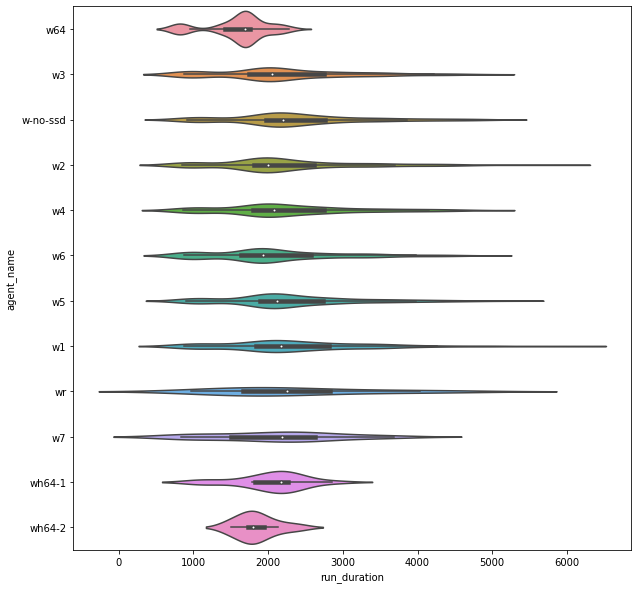

In [173]:
  fig, ax = plt.subplots(figsize=(10,10)) # size of the plot (width, height)

  sns.violinplot(
        ax=ax,
        x='run_duration',
        y='agent_name',
        split=True,
        data=ds)

In [174]:
t = pd.pivot_table(ds, values=['run_duration'], index=['agent_name'],
                    aggfunc=[np.median, np.mean, np.std, np.count_nonzero])
t = t.reindex(t.sort_values(by=('median', 'run_duration'), ascending=False).index)
t

,median,mean,std,count_nonzero
,run_duration,run_duration,run_duration,run_duration
agent_name,,,,
wr,2253.1580,2358.452667,1063.643825,15.0
w-no-ssd,2205.6560,2384.878086,903.300255,327.0
w7,2183.6010,2105.768773,838.872186,22.0
wh64-1,2171.9305,2030.448714,458.938941,14.0
w1,2167.8730,2337.174326,946.209905,276.0
w5,2120.6475,2298.384057,864.067277,350.0
w4,2085.1555,2259.117868,894.307199,340.0
w3,2052.3355,2205.881979,901.605416,374.0
